In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d

from kan import *
from use_training_set import *
import use_KAN
# from use_KAN import *


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
cpu = torch.device('cpu')
device = cpu

## load model

In [3]:
# fname_setup = 'setup_model_13_9.txt'
string_setting = "10-1_8_g_12_16_raw"
# string_setting = "9_7_g_16_16_cos"
fname_setup = f'setup_model_{string_setting}.txt'
with open(fname_setup, 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)
# model_KAN = use_KAN.build_model_cos(config['Model Setup'], device=device)

Device set to: cpu
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


### load training set

In [4]:
config_file = 'setup_ts.txt'
x_train, y_train, Q_train = load_training_data(config_file, extend=True, sm=False)
print(x_train.shape)
print(y_train.shape)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)
I_train = np.exp(y_train)

logk_z = x_train[:, 0]
k_z = np.exp(logk_z)
# logk_z = np.log(k_z)
alpha = x_train[:, 2]
logkappa = x_train[:, 1]
kappa = np.exp(logkappa)
# logkappa = np.log(kappa)
set_k_z = np.unique(logk_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique((logkappa)))


k_z in
[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   2.   3.   4.   5.
  6.   7.   8.   9.  10. ]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]
(4000, 3)
(4000, 126)


In [5]:
## use the log_Q background model
# Qx = np.vstack([Q_train, np.ones_like(Q_train)]).T
# Qx = np.vstack([np.log(Q_train), np.ones_like(Q_train)]).T
# f_Qx = lambda Q: np.vstack([np.log(Q),np.ones_like(Q)]).T
f_Qx = lambda Q: np.vstack([Q,np.ones_like(Q)]).T
# f_Qx = lambda Q: np.vstack([np.cos(2*np.pi*Q/1),np.cos(2*np.pi*Q/2),np.cos(2*np.pi*Q/4),np.cos(2*np.pi*Q/8),np.cos(2*np.pi*Q/16), np.ones_like(Q)]).T
use_KAN.update_Qx(f_Qx=f_Qx, config=config)

Qx and Qx_inv have been defined and updated.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Model has been redefined.


### load trained model parameters

In [6]:
# fname_BR = "./saved_model/KAN/model_13_9_grid_ft_lin_monoc.pth"
fname_BR = f"./saved_model/KAN/model_{string_setting}.pth"
model_KAN.load_state_dict(torch.load(fname_BR))

<All keys matched successfully>

## define function to generate I(Q)

In [7]:
# def f_IQ_KAN(model, x, Q):
#     Qx_sample = use_KAN.to_torch_device(np.vstack([Q,np.ones_like(Q)]).T, device=device)
    
#     # Transform x using kan_aug
#     n_data = x.shape[0]
#     x = x.view(-1, 3)
#     # x[:,0] = np.exp(x[:,0])
#     # x[:,1] = np.exp(x[:,1])
#     x_transformed = model.kan_aug(x)
    
#     # Transform Q using to_torch_device
#     Q_torch = use_KAN.to_torch_device((Q - 2) / 4, device=device)
    
#     # Calculate bg
#     bg = (x @ model.A + model.B)
#     # bg_expanded = bg.unsqueeze(1).expand(-1, self.Q_torch.size(0), -1)
#     # Compute the mean of individual bg
#     # bg_mean = bg_expanded.mean(dim=-1)
#     # Linear approximation of the background
#     Qab = use_KAN.Qx_inv@bg.T
#     bg_lin = (Qx_sample@Qab).T
    
#     # Expand dimensions to match Q_torch
#     x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch.size(0), -1)
#     Q_expanded = Q_torch.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
#     # Combine Q and x
#     Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
#     Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
#     # Produce f(Q, x) using kan
#     f_Q_x = model.kan(Q_params_reshaped)
#     f_Q_x_reshaped = f_Q_x.view(x.size(0), Q_torch.size(0))
    
#     # print(f_Q_x_reshaped.shape)
#     # print(bg_mean)    
#     # Add bg to the final output
#     return f_Q_x_reshaped*model.multiplier + bg_lin

f_IQ_KAN = lambda model, x, Q: use_KAN.f_IQ_KAN(model, x, Q, f_Qx=f_Qx)
# f_IQ_KAN = lambda model, x, Q: use_KAN.f_IQ_KAN_cos(model, x, Q, f_Qx=f_Qx)

In [8]:
x_train_torch

tensor([[ 0.0000, -1.3863,  0.0000],
        [ 0.6931, -1.3863,  0.0000],
        [ 1.0986, -1.3863,  0.0000],
        ...,
        [-0.2231,  4.5055,  0.9000],
        [-0.1054,  4.5055,  0.9000],
        [ 0.0000,  4.5055,  0.9000]])

## plotting results

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

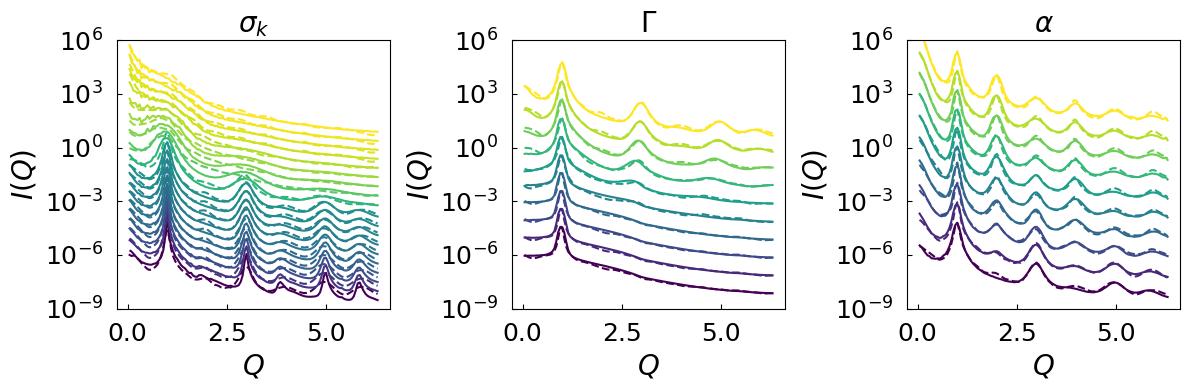

In [9]:
# indexing
def id_params(parameters):
    tol = 1e-3
    id_k_z = np.abs(logk_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[2])<tol
    id_kappa = np.abs(logkappa-parameters[1])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

# color
def color_params(parameters):
    k_z_reduced = np.clip((np.exp(parameters[0]) - np.exp(set_k_z.min())) / (np.exp(set_k_z.max()) - np.exp(set_k_z.min())), 0, 1)
    alpha_reduced = np.clip((parameters[2] - set_alpha.min()) / (set_alpha.max() - set_alpha.min()), 0, 1)
    kappa_reduced = np.clip((parameters[1] - set_kappa.min()) / (set_kappa.max() - set_kappa.min()), 0, 1)
    return [k_z_reduced, 1-kappa_reduced, alpha_reduced]

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
colormap = plt.cm.get_cmap('viridis')

# Plot results: varying k_z
for i, k_z_i in enumerate(set_k_z):
    parameters = [set_k_z[i], set_kappa[0], set_alpha[0]]
    index = id_params(parameters)
    
    color = colormap((set_k_z[i]-np.min(set_k_z))/(np.max(set_k_z)-np.min(set_k_z)))

    axs[0].plot(Q_train, I_train[index,]*10**(i/2), '-', color=color)
    
    I_kan = np.exp(f_IQ_KAN(model_KAN, x_train_torch[index], Q_train).detach().cpu().numpy())
    axs[0].plot(Q_train, I_kan[0]*10**(i/2), '--', color=color)

axs[0].set_xlabel(r'$Q$', fontsize=20)
axs[0].set_ylabel(r'$I(Q)$', fontsize=20)
axs[0].set_yscale('log')
axs[0].tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
axs[0].set_title('$\sigma_k$', fontsize=20)

# Plot results: varying kappa (every two values)
for i, kappa_i in enumerate(set_kappa[::-2]):
    parameters = [set_k_z[9], kappa_i, set_alpha[0]]
    index = id_params(parameters)
    
    color = colormap((kappa_i-np.min(set_kappa[::-2]))/(np.max(set_kappa[::-2])-np.min(set_kappa[::-2])))

    axs[1].plot(Q_train, I_train[index,]*10**i, '-', color=color)
    
    I_kan = np.exp(f_IQ_KAN(model_KAN, x_train_torch[index], Q_train).detach().cpu().numpy())
    axs[1].plot(Q_train, I_kan[0]*10**i, '--', color=color)

axs[1].set_xlabel(r'$Q$', fontsize=20)
axs[1].set_ylabel(r'$I(Q)$', fontsize=20)
axs[1].set_yscale('log')
axs[1].tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
axs[1].set_title('$\\Gamma$', fontsize=20)

# Plot results: varying alpha
for i, alpha_i in enumerate(set_alpha):
    parameters = [set_k_z[9], set_kappa[0], set_alpha[i]]
    index = id_params(parameters)
    
    color = colormap((set_alpha[i]-np.min(set_alpha))/(np.max(set_alpha)-np.min(set_alpha)))

    axs[2].plot(Q_train, I_train[index,]*10**i, '-', color=color)
    
    I_kan = np.exp(f_IQ_KAN(model_KAN, x_train_torch[index], Q_train).detach().cpu().numpy())
    axs[2].plot(Q_train, I_kan[0]*10**i, '--', color=color)

axs[2].set_xlabel(r'$Q$', fontsize=20)
axs[2].set_ylabel(r'$I(Q)$', fontsize=20)
axs[2].set_yscale('log')
axs[2].tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
axs[2].set_title('$\\alpha$', fontsize=20)

# Set consistent ylim and maintain aspect ratio
for ax in axs:
    ax.set_ylim([1e-9, 1e6])  # Example ylim, adjust as needed
    ax.set_aspect(aspect='auto')

plt.tight_layout()
plt.show()

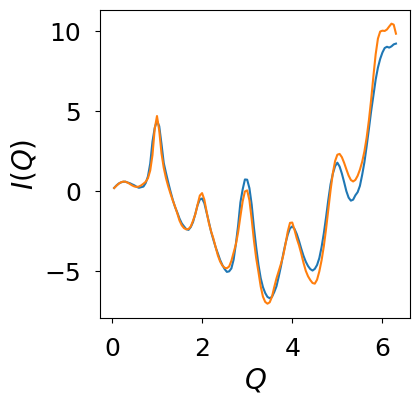

In [10]:
parameters = [set_k_z[9], set_kappa[2], set_alpha[2]]
index = id_params(parameters)
x = x_train_torch[[index]]

x = x.view(-1, 3)
x_transformed = model_KAN.kan_aug(x)

# Transform Q using to_torch_device
Q_torch = use_KAN.to_torch_device((Q_train - 2) / 4, device=device)

# Calculate bg
bg = (x @ model_KAN.A + model_KAN.B)
Qx = np.vstack([Q_train**2,np.ones_like(Q_train)]).T
Qx_inv = use_KAN.to_torch_device((np.linalg.pinv(Qx)), device=device)
Qx_torch = use_KAN.to_torch_device(Qx, device=device)
Qab = Qx_inv@bg.T

bg_lin = (Qx_torch@Qab).detach().cpu().numpy()[:,0]

y_kan = f_IQ_KAN(model_KAN, x, Q_train).detach().cpu().numpy()[0,:]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Q_train, (y_train[index].T-bg_lin)*Q_train,'-')
ax.plot(Q_train, (y_kan-bg_lin)*Q_train,'-')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, pad=10)
# ax.set_xscale('log')
# ax.plot(Q_train, bg.detach().cpu().numpy()[0,:],'-')
# ax.plot(Q_train, bg_lin,'--')

/tmp/ipykernel_615307/2785236394.py:5: RuntimeWarning: divide by zero encountered in log
  x_ext = np.array([[np.log(1-i/10),np.log(64),0]])


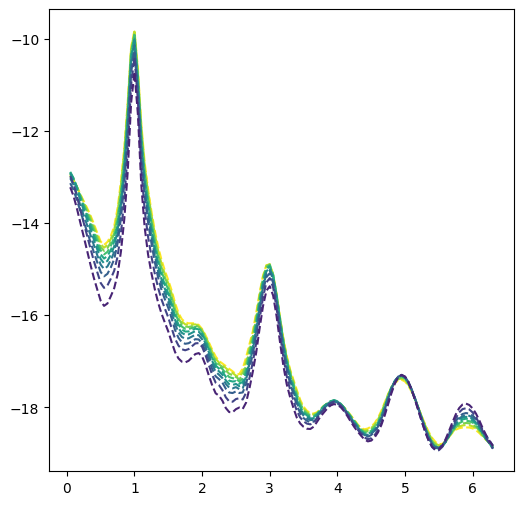

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i in range(11):
    x_ext = np.array([[np.log(1-i/10),np.log(64),0]])
    color = colormap(1-i/10)
    y_kan = f_IQ_KAN(model_KAN, use_KAN.to_torch_device(x_ext,device=device), Q_train).detach().cpu().numpy()[0,:]

    ax.plot(Q_train, y_kan,'--', color=color)

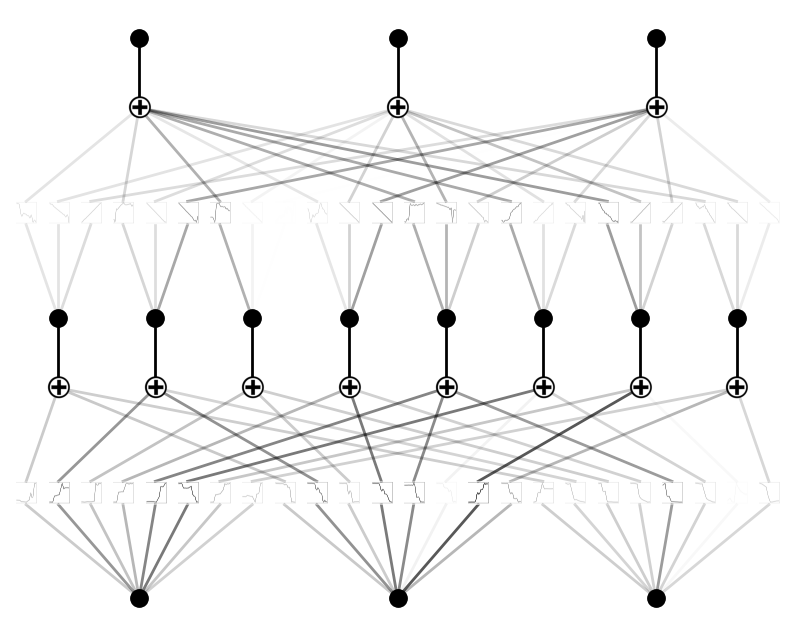

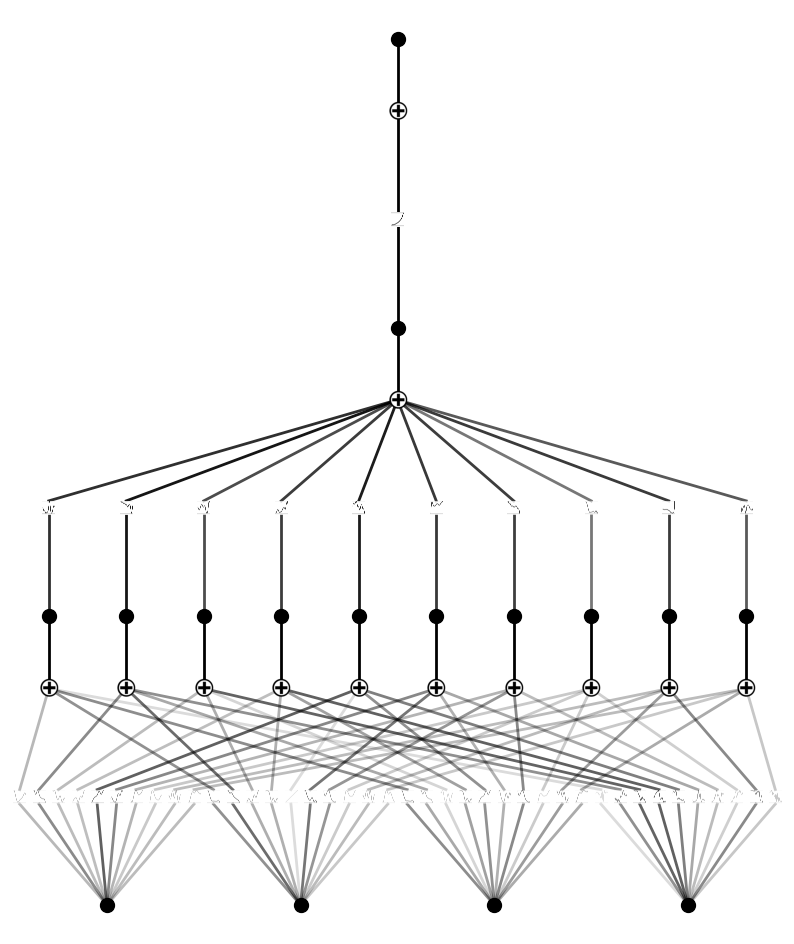

In [12]:
model_KAN(x_train_torch)
model_KAN.kan_aug.plot(scale=1)
model_KAN.kan.plot(scale=1)